## Final waste classification model

## Import libaraies

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow.lite as tflite
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import zscore

## Load data set

In [5]:
train_path = "D:/VSCODE/CNN model waste classification/DATASET/TRAIN"
test_path = "D:/VSCODE/CNN model waste classification/DATASET/TEST"

## Data Augmentation and validation

In [6]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.4, 1.6],
    shear_range=0.3,
    zoom_range=0.4,
    horizontal_flip=True,
    validation_split=0.2
)

# Load Train and Validation Data
train_generator = datagen.flow_from_directory(train_path, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory(train_path, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='validation')

# Transfer Learning with MobileNetV2
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Model Definition
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.


## Train model

In [7]:
history = model.fit(train_generator, validation_data=val_generator, epochs=25, callbacks=[early_stopping, lr_scheduler])

C:\Users\deepa\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
565/565 ━━━━━━━━━━━━━━━━━━━━ 125s 215ms/step - accuracy: 0.8370 - loss: 0.4143 - val_accuracy: 0.9107 - val_loss: 0.2417 - learning_rate: 0.0010
Epoch 2/25
565/565 ━━━━━━━━━━━━━━━━━━━━ 111s 196ms/step - accuracy: 0.8881 - loss: 0.2825 - val_accuracy: 0.9089 - val_loss: 0.2351 - learning_rate: 0.0010
Epoch 3/25
565/565 ━━━━━━━━━━━━━━━━━━━━ 119s 211ms/step - accuracy: 0.8895 - loss: 0.2709 - val_accuracy: 0.9094 - val_loss: 0.2196 - learning_rate: 0.0010
Epoch 4/25
565/565 ━━━━━━━━━━━━━━━━━━━━ 120s 212ms/step - accuracy: 0.8906 - loss: 0.2658 - val_accuracy: 0.9125 - val_loss: 0.2280 - learning_rate: 0.0010
Epoch 5/25
565/565 ━━━━━━━━━━━━━━━━━━━━ 121s 214ms/step - accuracy: 0.8941 - loss: 0.2615 - val_accuracy: 0.9215 - val_loss: 0.2150 - learning_rate: 0.0010
Epoch 6/25
565/565 ━━━━━━━━━━━━━━━━━━━━ 117s 207ms/step - accuracy: 0.9012 - loss: 0.2513 - val_accuracy: 0.9140 - val_loss: 0.2181 - learning_rate: 0.0010
Epoch 7/25
565/565 ━━━━━━━━━━━━━━━━━━━━ 112s 198ms/step - accura

Found 2513 images belonging to 2 classes.


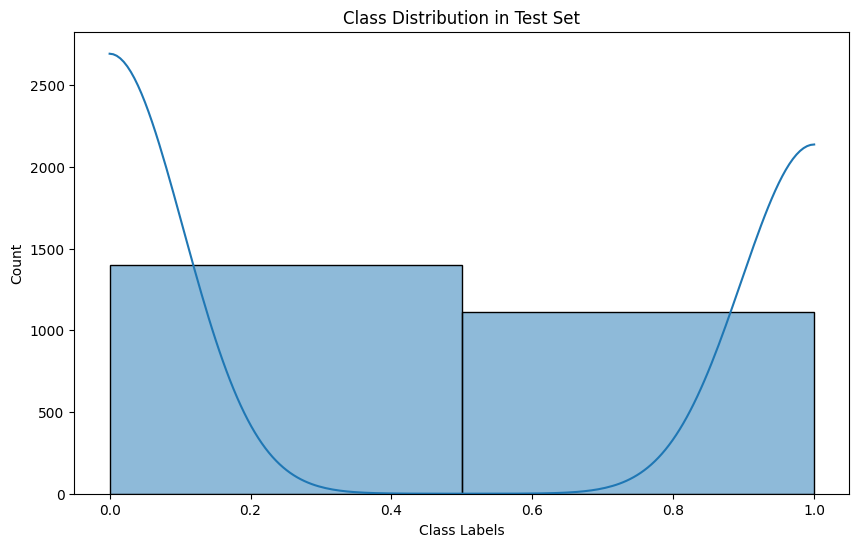

In [9]:
# Load test data
test_generator = datagen.flow_from_directory(
    test_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Extract true labels from test generator
y_true = test_generator.classes  # Correct way to get true labels

# Now plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(y_true, bins=len(train_generator.class_indices), kde=True)
plt.title("Class Distribution in Test Set")
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.show()


## visual

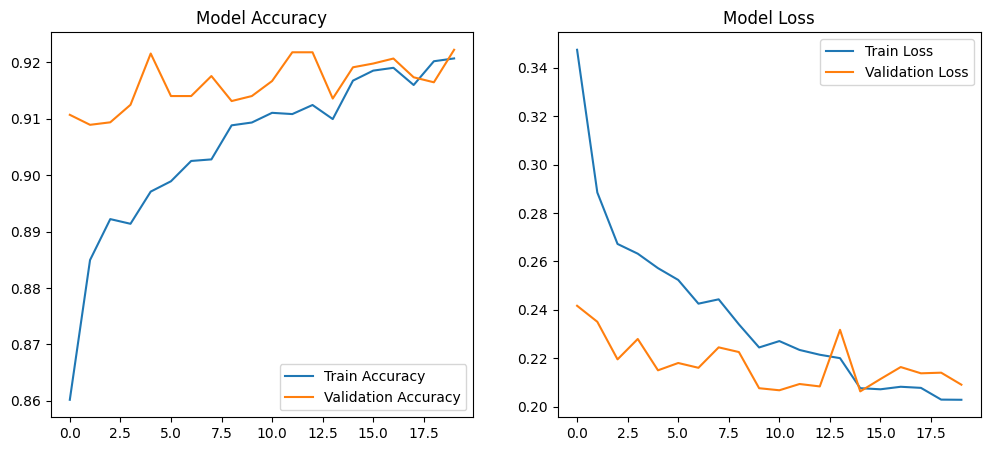

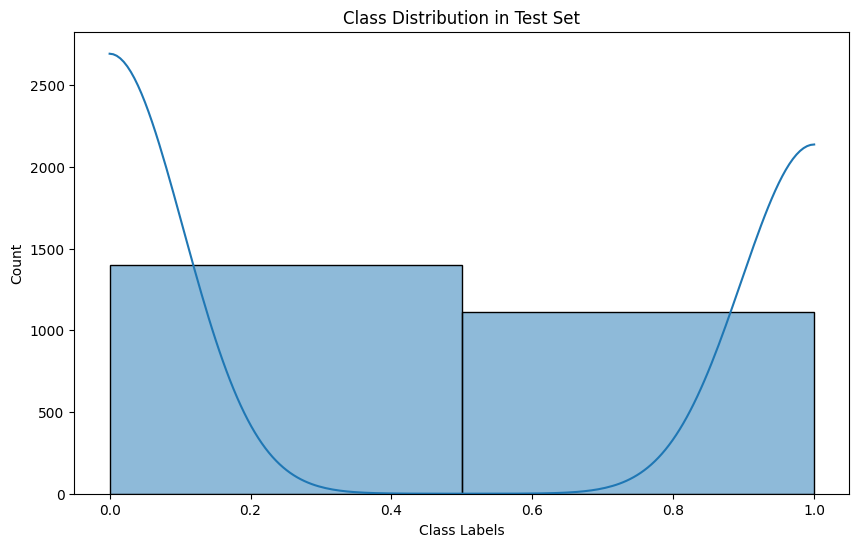

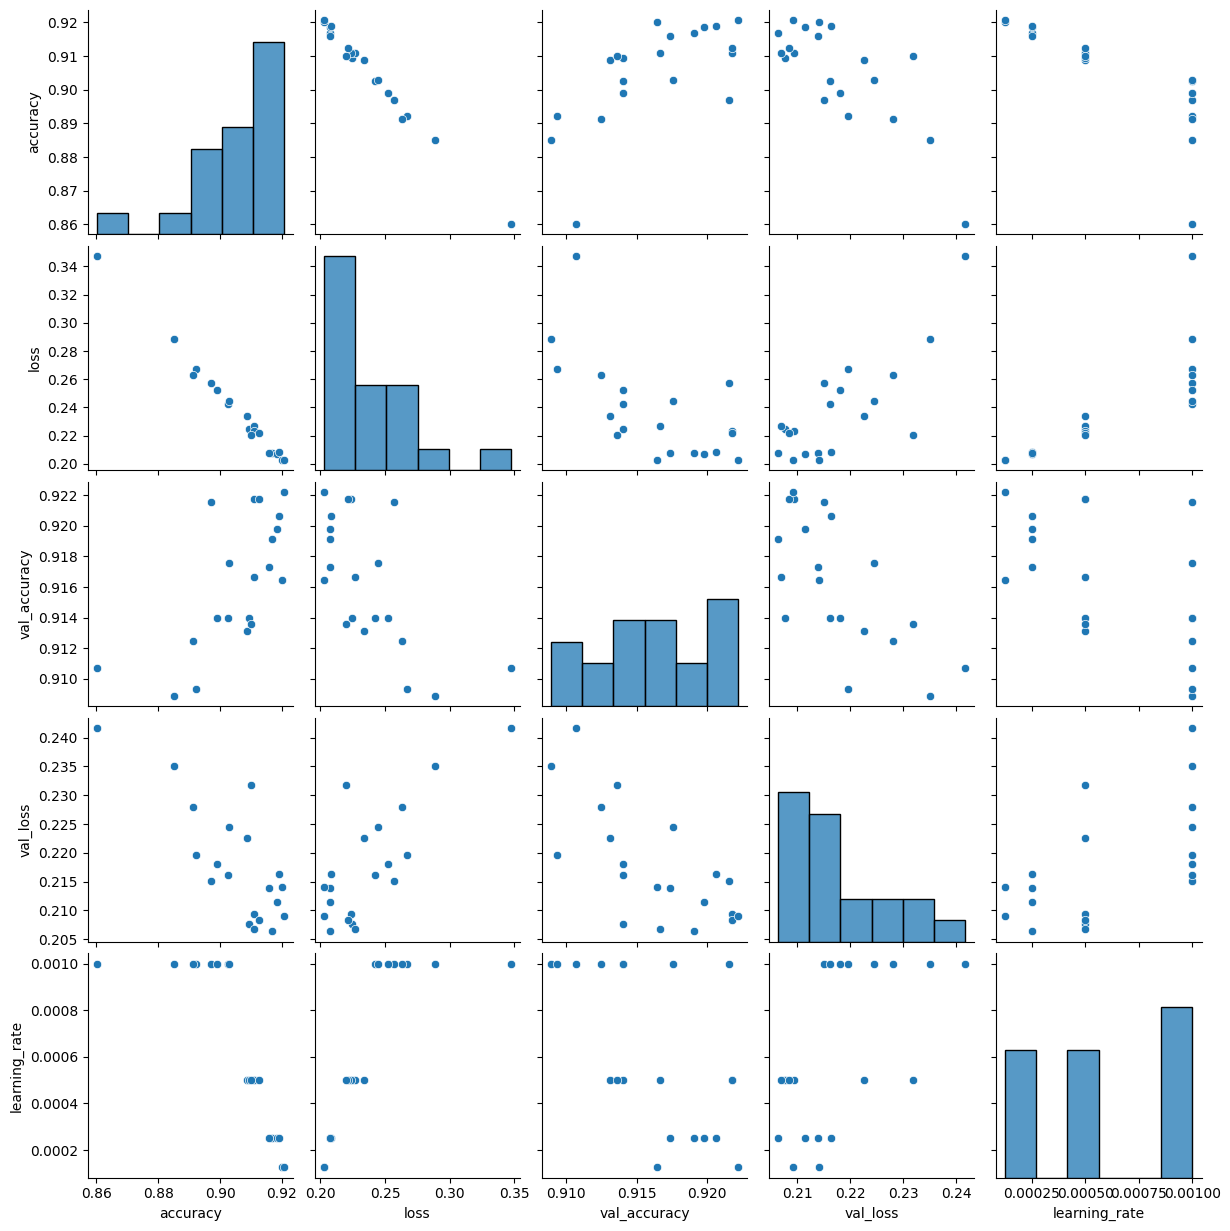

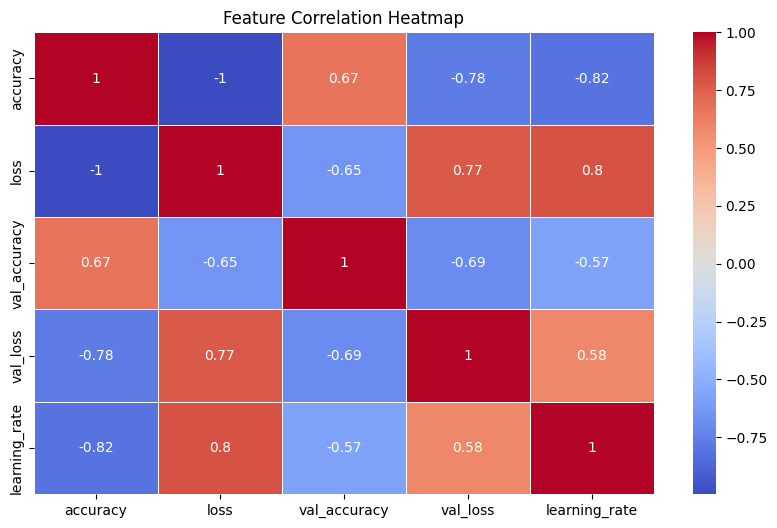

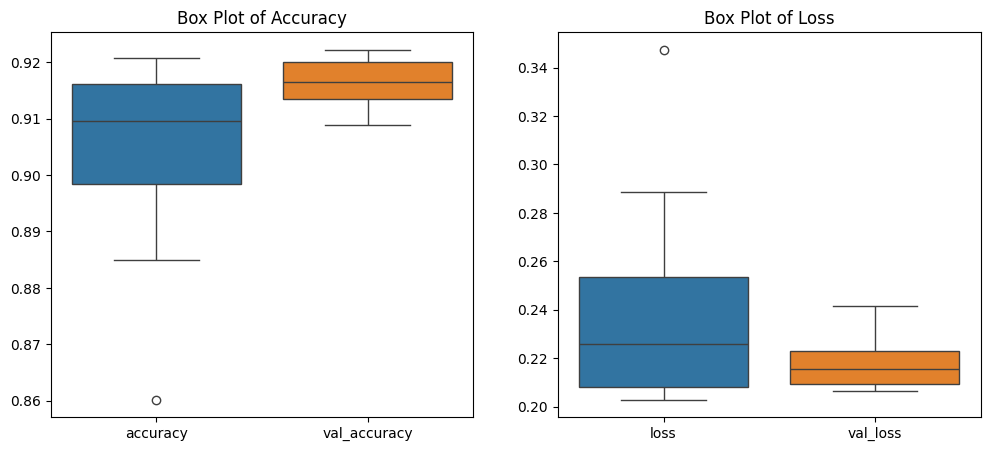

In [10]:
# Visualization: Accuracy & Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

# Additional Visualizations
plt.figure(figsize=(10, 6))
sns.histplot(y_true, bins=len(train_generator.class_indices), kde=True)
plt.title("Class Distribution in Test Set")
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.show()

sns.pairplot(pd.DataFrame(history.history))
plt.show()

# Correlation Heatmap
correlation_matrix = pd.DataFrame(history.history).corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Box Plot of Accuracy & Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=pd.DataFrame(history.history)[['accuracy', 'val_accuracy']])
plt.title("Box Plot of Accuracy")

plt.subplot(1, 2, 2)
sns.boxplot(data=pd.DataFrame(history.history)[['loss', 'val_loss']])
plt.title("Box Plot of Loss")
plt.show()

## Analysis

c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  

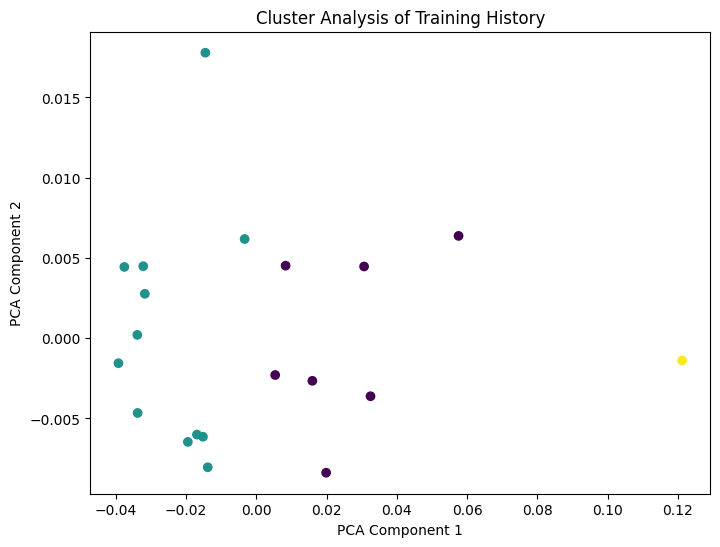

Anomalies detected at epochs: [0]


In [11]:
# Cluster Analysis
pca = PCA(n_components=2)
history_pca = pca.fit_transform(pd.DataFrame(history.history))
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(history_pca)
plt.figure(figsize=(8, 6))
plt.scatter(history_pca[:, 0], history_pca[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Cluster Analysis of Training History")
plt.show()

# Anomaly Detection
z_scores = np.abs(zscore(pd.DataFrame(history.history)))
anomalies = np.where(z_scores > 3)
print("Anomalies detected at epochs:", np.unique(anomalies[0]))

## Report

Found 2513 images belonging to 2 classes.


C:\Users\deepa\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step


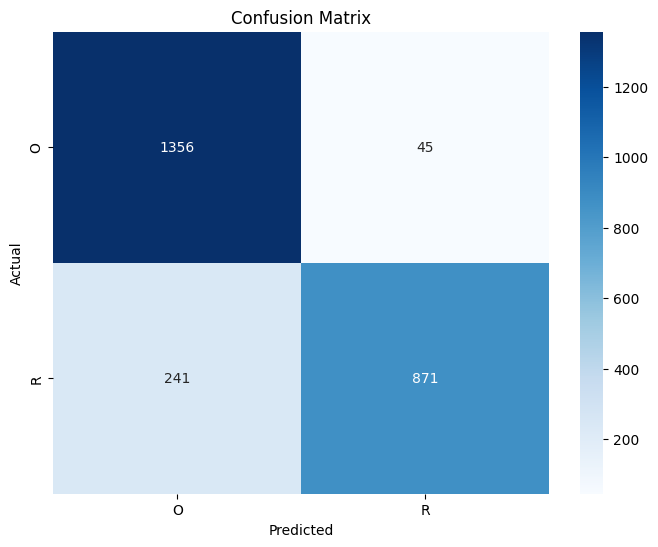

              precision    recall  f1-score   support

           O       0.85      0.97      0.90      1401
           R       0.95      0.78      0.86      1112

    accuracy                           0.89      2513
   macro avg       0.90      0.88      0.88      2513
weighted avg       0.89      0.89      0.88      2513



In [12]:
# Confusion Matrix & Classification Report
def evaluate_model():
    test_generator = datagen.flow_from_directory(test_path, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False)
    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

evaluate_model()

## convert to ft

In [13]:
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open("waste_classification.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model saved.")

INFO:tensorflow:Assets written to: C:\Users\deepa\AppData\Local\Temp\tmpihzxh6v6\assets


INFO:tensorflow:Assets written to: C:\Users\deepa\AppData\Local\Temp\tmpihzxh6v6\assets


Saved artifact at 'C:\Users\deepa\AppData\Local\Temp\tmpihzxh6v6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  1642142010448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1642142011216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1642142013136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1642142012752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1642142011600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1642142013328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1642142012368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1642142010640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1642142013520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1642142011408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1